In [1]:
# Importing all Libraries
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from tensorflow.keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from tensorflow.keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
import tqdm.notebook as tq
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy

### Bottle Neck Features
* <b>Model used:</b>  VGG16
* All <b>Bottleneck Features</b> from sequential model of VGG16 each feature dataset is saved as .npy file, to be classified.

In [2]:
# Setting input dataset size and batch size
img_width, img_height = 64, 64 
batch_size = 350

In [10]:
for dataset in tq.tqdm(range(6)):
    
    DATASET_NAMES = ["fullImage","Mouth","LeftEye","RightEye","Nose","Forehead"]
    train_data_dir = r'FinalMultiFer2013/Dataset{}/train'.format(dataset)
    val_data_dir = r'FinalMultiFer2013/Dataset{}/val'.format(dataset)
    start = datetime.datetime.now()
    
    # Loading Data
    train_Datagenerator = ImageDataGenerator(rotation_range=20,
                                             rescale=1./255,
                                             shear_range=0.1,
                                             zoom_range=0.2,
                                             horizontal_flip=True,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1) 
    
    val_Datagenerator = ImageDataGenerator(rescale=1./255)

    generator_train = train_Datagenerator.flow_from_directory(train_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size, 
                                                  class_mode='categorical',
                                                  seed = 2, 
                                                  shuffle=False)
    
    generator_val = val_Datagenerator.flow_from_directory(val_data_dir, 
                                                target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical', 
                                                shuffle=False)

    
    # Create custom VGG16 Model
    base_model = applications.VGG16(include_top=False, 
                               weights='imagenet',
                               input_shape=generator_train.image_shape)
    
    for layer in base_model.layers[:15]:
        layer.trainable = False
    
    
    """modelTemp = Sequential()
    for layer in base_model.layers[:-1]:
        modelTemp.add(layer)
    base_model = modelTemp"""

    # Classifier
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(512, activation='relu')
    drop_out_1 = layers.Dropout(0.3)
    dense_layer_2 = layers.Dense(256, activation='relu')
    drop_out_2 = layers.Dropout(0.3)
    dense_layer_3 = layers.Dense(100, activation='relu')
    prediction_layer = layers.Dense(7, activation='softmax')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        drop_out_1,
        # dense_layer_2,
        # drop_out_2,
        dense_layer_3,
        prediction_layer
    ])

    # Compile and Fit
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    es = EarlyStopping(monitor='val_accuracy', mode='max', 
                       patience=20,  restore_best_weights=True)

    history = model.fit(generator_train,
                        validation_data=generator_val, 
                        steps_per_epoch=200, 
                        epochs=100,
                        batch_size=2,
                        callbacks=[es])

    # Predict and Save Features
    nb_train_samples = len(generator_train.filenames) 
    num_classes = len(generator_train.class_indices)

    nb_val_samples = len(generator_val.filenames) 
    num_classes = len(generator_val.class_indices)  

    predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
    predict_size_val = int(math.ceil(nb_train_samples / batch_size)) 

    dataset_features_train = model.layers[0].predict(generator_train, predict_size_train) 
    dataset_features_valid = model.layers[0].predict(generator_val, predict_size_val)

    BOTTLENECK_SAVE_PATH_Train = r'FerModels/train/{}_bottleneck_features.npy'.format(DATASET_NAMES[dataset])
    BOTTLENECK_SAVE_PATH_Val = r'FerModels/val/{}_bottleneck_features.npy'.format(DATASET_NAMES[dataset])
    np.save(BOTTLENECK_SAVE_PATH_Train, dataset_features_train)
    np.save(BOTTLENECK_SAVE_PATH_Val, dataset_features_valid)

    print(DATASET_NAMES[dataset], "Train","Shape: {}".format(dataset_features_train.shape))
    print(DATASET_NAMES[dataset], "Val","Shape: {}".format(dataset_features_valid.shape))
    end = datetime.datetime.now()
    elapsed= end-start
    print (f'Time training{dataset}: ', elapsed)

  0%|          | 0/6 [00:00<?, ?it/s]

Found 778 images belonging to 7 classes.
Found 196 images belonging to 7 classes.
Epoch 1/100
200/200 [==============================] - 17s 82ms/step - loss: 2.0284 - accuracy: 0.2100 - val_loss: 1.8899 - val_accuracy: 0.2551
Epoch 2/100
200/200 [==============================] - 16s 80ms/step - loss: 1.8755 - accuracy: 0.2375 - val_loss: 1.8437 - val_accuracy: 0.2092
Epoch 3/100
200/200 [==============================] - 16s 80ms/step - loss: 1.8244 - accuracy: 0.2425 - val_loss: 1.8334 - val_accuracy: 0.2551
Epoch 4/100
200/200 [==============================] - 16s 81ms/step - loss: 1.7964 - accuracy: 0.2575 - val_loss: 1.8325 - val_accuracy: 0.2551
Epoch 5/100
200/200 [==============================] - 16s 81ms/step - loss: 2.4560 - accuracy: 0.2325 - val_loss: 1.8400 - val_accuracy: 0.2704
Epoch 6/100
200/200 [==============================] - 16s 81ms/step - loss: 1.8814 - accuracy: 0.2925 - val_loss: 1.8605 - val_accuracy: 0.2551
Epoch 7/100
200/200 [===========================

Epoch 48/100
200/200 [==============================] - 15s 75ms/step - loss: 1.1148 - accuracy: 0.5975 - val_loss: 1.5190 - val_accuracy: 0.5663
Epoch 49/100
200/200 [==============================] - 15s 77ms/step - loss: 1.1044 - accuracy: 0.6175 - val_loss: 1.0742 - val_accuracy: 0.6224
Epoch 50/100
200/200 [==============================] - 15s 77ms/step - loss: 1.1025 - accuracy: 0.6300 - val_loss: 0.9994 - val_accuracy: 0.6122
Epoch 51/100
200/200 [==============================] - 15s 76ms/step - loss: 1.2334 - accuracy: 0.5750 - val_loss: 1.0158 - val_accuracy: 0.6429
Epoch 52/100
200/200 [==============================] - 15s 77ms/step - loss: 1.0904 - accuracy: 0.6300 - val_loss: 0.9702 - val_accuracy: 0.6531
Epoch 53/100
200/200 [==============================] - 15s 77ms/step - loss: 1.1454 - accuracy: 0.5925 - val_loss: 0.9303 - val_accuracy: 0.6582
Epoch 54/100
200/200 [==============================] - 15s 77ms/step - loss: 1.1715 - accuracy: 0.5850 - val_loss: 1.1546 -

Epoch 3/100
200/200 [==============================] - 16s 78ms/step - loss: 1.7191 - accuracy: 0.3300 - val_loss: 2.1793 - val_accuracy: 0.2551
Epoch 4/100
200/200 [==============================] - 16s 78ms/step - loss: 1.6492 - accuracy: 0.3675 - val_loss: 1.4663 - val_accuracy: 0.4388
Epoch 5/100
200/200 [==============================] - 15s 77ms/step - loss: 1.5083 - accuracy: 0.4250 - val_loss: 1.3744 - val_accuracy: 0.4490
Epoch 6/100
200/200 [==============================] - 15s 77ms/step - loss: 1.4591 - accuracy: 0.4800 - val_loss: 1.3091 - val_accuracy: 0.4694
Epoch 7/100
200/200 [==============================] - 15s 77ms/step - loss: 1.3607 - accuracy: 0.5025 - val_loss: 1.9076 - val_accuracy: 0.3571
Epoch 8/100
200/200 [==============================] - 15s 77ms/step - loss: 1.4008 - accuracy: 0.5275 - val_loss: 1.2715 - val_accuracy: 0.5255
Epoch 9/100
200/200 [==============================] - 15s 77ms/step - loss: 1.1845 - accuracy: 0.5775 - val_loss: 1.4080 - val_ac

Epoch 21/100
200/200 [==============================] - 15s 77ms/step - loss: 1.8443 - accuracy: 0.2600 - val_loss: 1.8284 - val_accuracy: 0.2551
Epoch 22/100
200/200 [==============================] - 15s 77ms/step - loss: 1.9738 - accuracy: 0.2575 - val_loss: 7.8877 - val_accuracy: 0.2551
Epoch 23/100
200/200 [==============================] - 15s 77ms/step - loss: 2.0944 - accuracy: 0.2100 - val_loss: 1.8255 - val_accuracy: 0.3622
Epoch 24/100
200/200 [==============================] - 15s 77ms/step - loss: 1.9123 - accuracy: 0.2250 - val_loss: 1.8491 - val_accuracy: 0.2551
Epoch 25/100
200/200 [==============================] - 15s 77ms/step - loss: 1.8512 - accuracy: 0.2425 - val_loss: 1.8031 - val_accuracy: 0.2551
Epoch 26/100
200/200 [==============================] - 15s 77ms/step - loss: 1.8440 - accuracy: 0.3475 - val_loss: 1.6026 - val_accuracy: 0.4337
Epoch 27/100
200/200 [==============================] - 15s 77ms/step - loss: 1.7577 - accuracy: 0.3825 - val_loss: 1.6515 -

200/200 [==============================] - 16s 80ms/step - loss: 1.1836 - accuracy: 0.5250 - val_loss: 1.2212 - val_accuracy: 0.5357
Epoch 33/100
200/200 [==============================] - 16s 80ms/step - loss: 1.2326 - accuracy: 0.4925 - val_loss: 1.8655 - val_accuracy: 0.4184
Epoch 34/100
200/200 [==============================] - 16s 81ms/step - loss: 1.2186 - accuracy: 0.5475 - val_loss: 1.0698 - val_accuracy: 0.5663
Epoch 35/100
200/200 [==============================] - 16s 80ms/step - loss: 1.1229 - accuracy: 0.5850 - val_loss: 1.0454 - val_accuracy: 0.5867
Epoch 36/100
200/200 [==============================] - 16s 82ms/step - loss: 1.1898 - accuracy: 0.5375 - val_loss: 1.2472 - val_accuracy: 0.5816
Epoch 37/100
200/200 [==============================] - 16s 81ms/step - loss: 1.1954 - accuracy: 0.5825 - val_loss: 1.1561 - val_accuracy: 0.5765
Epoch 38/100
200/200 [==============================] - 16s 80ms/step - loss: 1.1733 - accuracy: 0.5600 - val_loss: 1.1461 - val_accuracy

### Stacking all BottleNeck Features

In [26]:
# Appending all bottle neck features to a single list 

FEATURES_STACK_TRAINX = []
FEATURES_STACK_VALX = []
FEATURES_STACK_TRAINY = []
FEATURES_STACK_VALY = []
DATASET_NAMES = ["fullImage","Nose","Mouth","LeftEye","RightEye","Forehead"]
# DATASET_NAMES = ["fullImage"] # for Single 
TRAIN_VAL = ["train","val"]

Datagenerator = ImageDataGenerator(rescale=1./255)

for i in range(len(DATASET_NAMES)):
    for j in TRAIN_VAL:
        data_dir = r'FinalMultiCK+/Dataset{}/{}'.format(i,j)
        generator = Datagenerator.flow_from_directory(data_dir, 
                                                target_size=(img_width, img_height),
                                                batch_size=batch_size, 
                                                class_mode='categorical', 
                                                shuffle=False) 

        nb_train_samples = len(generator.filenames) 
        num_classes = len(generator.class_indices) 

        data = np.load(r'CKModels/{}/{}_bottleneck_features.npy'.format(j,DATASET_NAMES[i])) 
        labels = generator.classes 
        labels = to_categorical(labels, num_classes=num_classes)
        
        if j in "val":
            FEATURES_STACK_VALX.append(data) 
            FEATURES_STACK_VALY.append(labels)
        else:
            FEATURES_STACK_TRAINX.append(data)
            FEATURES_STACK_TRAINY.append(labels)

Found 778 images belonging to 7 classes.
Found 196 images belonging to 7 classes.
Found 778 images belonging to 7 classes.
Found 196 images belonging to 7 classes.
Found 778 images belonging to 7 classes.
Found 196 images belonging to 7 classes.
Found 778 images belonging to 7 classes.
Found 196 images belonging to 7 classes.
Found 778 images belonging to 7 classes.
Found 196 images belonging to 7 classes.
Found 778 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [27]:
# Stacking them all together
STACKED_FEATURES_TRAINX = FEATURES_STACK_TRAINX[0]
for FEATURES in FEATURES_STACK_TRAINX[1:]:
    STACKED_FEATURES_TRAINX = np.concatenate((STACKED_FEATURES_TRAINX,FEATURES),axis=3)
    
STACKED_FEATURES_VALX = FEATURES_STACK_VALX[0]
for FEATURES in FEATURES_STACK_VALX[1:]:
    STACKED_FEATURES_VALX = np.concatenate((STACKED_FEATURES_VALX,FEATURES),axis=3)
    
STACKED_FEATURES_TRAINY = FEATURES_STACK_TRAINY[0]
    
STACKED_FEATURES_VALY = FEATURES_STACK_VALY[0]

In [28]:
# Final Shapes
print("Train shape X: ",STACKED_FEATURES_TRAINX.shape)
print("Train shape Y: ",STACKED_FEATURES_TRAINY.shape)
print("Val shape X: ",STACKED_FEATURES_VALX.shape)
print("Val shape Y: ",STACKED_FEATURES_VALY.shape)

Train shape X:  (778, 2, 2, 3072)
Train shape Y:  (778, 7)
Val shape X:  (196, 2, 2, 3072)
Val shape Y:  (196, 7)


In [29]:
# Final Classifier
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=STACKED_FEATURES_TRAINX.shape[1:])) 
model.add(Dense(512, activation=keras.layers.LeakyReLU(alpha=0.01))) 
model.add(Dropout(0.7)) 
model.add(Dense(512, activation=keras.layers.LeakyReLU(alpha=0.03))) 
model.add(Dropout(0.5)) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.01))) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer='adam',
   metrics=['acc'])

history = model.fit(STACKED_FEATURES_TRAINX, STACKED_FEATURES_TRAINY, 
   epochs=40,
   validation_data=(STACKED_FEATURES_VALX, STACKED_FEATURES_VALY))
#model.save_weights(top_model_weights_path)

Epoch 1/40
25/25 [==============================] - 1s 30ms/step - loss: 1.0542 - acc: 0.6337 - val_loss: 0.3097 - val_acc: 0.9439
Epoch 2/40
25/25 [==============================] - 1s 25ms/step - loss: 0.4009 - acc: 0.8625 - val_loss: 0.1439 - val_acc: 0.9796
Epoch 3/40
25/25 [==============================] - 1s 25ms/step - loss: 0.3277 - acc: 0.8882 - val_loss: 0.1068 - val_acc: 0.9745
Epoch 4/40
25/25 [==============================] - 1s 27ms/step - loss: 0.2013 - acc: 0.9229 - val_loss: 0.1217 - val_acc: 0.9643
Epoch 5/40
25/25 [==============================] - 1s 26ms/step - loss: 0.2293 - acc: 0.9139 - val_loss: 0.0820 - val_acc: 0.9796
Epoch 6/40
25/25 [==============================] - 1s 29ms/step - loss: 0.1947 - acc: 0.9319 - val_loss: 0.0836 - val_acc: 0.9796
Epoch 7/40
25/25 [==============================] - 1s 26ms/step - loss: 0.1696 - acc: 0.9396 - val_loss: 0.0925 - val_acc: 0.9796
Epoch 8/40
25/25 [==============================] - 1s 27ms/step - loss: 0.1765 - a

In [30]:
# Val set Eualvation
(eval_loss, eval_accuracy) = model.evaluate( 
    STACKED_FEATURES_VALX, STACKED_FEATURES_VALY, batch_size=batch_size,     verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

1/1 [==============================] - 0s 34ms/step - loss: 0.0834 - acc: 0.9847
[INFO] accuracy: 98.47%
[INFO] Loss: 0.08338256925344467
Time:  0:00:26.674291


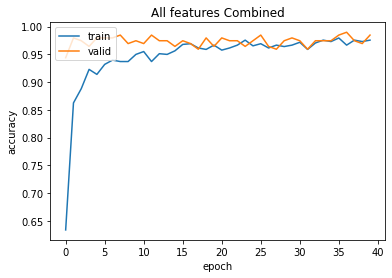

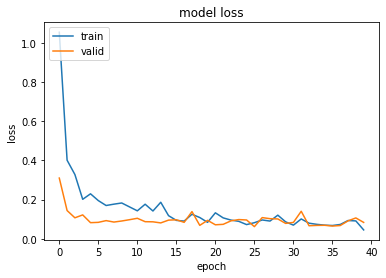

[INFO] accuracy: 98.47%
[INFO] Loss: 0.08338256925344467


In [31]:
# Plots and results
import matplotlib.pyplot as plt
import numpy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.title("All features Combined")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 